# Reproduction: Improved StyleGAN Embedding: Where are the Good Latents?

In this notebook, I will reproduce the process of the paper [Improved StyleGAN Embedding: Where are the Good Latents?](https://arxiv.org/abs/2012.09036). Particulary, we will implement the new spaces $P$, $P_N$ and $P_N^+$

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/internship/style-gan/

/content/gdrive/MyDrive/internship/style-gan


In [ ]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!pip install lpips
!pip install pytorch-ignite
!pip install pytorch-msssim

     |████████████████████████████████| 204kB 8.4MB/s 
     |████████████████████████████████| 112kB 22.7MB/s 
     |████████████████████████████████| 26.9MB 140kB/s 
     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 204kB 8.0MB/s 


In [ ]:
# Import the needed libraries
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import os
import IPython
from PIL import Image
import glob
from sklearn.decomposition import PCA
import numpy as np 
from torchvision.utils import save_image
from torchsummary import summary
from torchvision import models, transforms
from ignite.metrics import PSNR
from ignite.engine import Engine
from pytorch_msssim import ssim

import torch.optim as optim
import torch.nn.functional as F
import lpips
import warnings
import dnnlib
warnings.filterwarnings("ignore")

In [ ]:
# Setting global attributes
RESOLUTION = 1024
#DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERATIONS = 1300
SAVE_STEP = 100

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8
regularizer_lambda = 0.005

# IMAGE TO EMBED
#PATH_IMAGE = "stuff/data/expression02.png"
PATH_DIR = "stuff/data/input/"
EXPECTED_RESULTS = "stuff/data/Peihao_result/"
SAVING_DIR = 'stuff/results/synthetic_images_regulizer_v2/'

In [ ]:
DEVICE

device(type='cpu')

## Loadding Pretrained Model
Load the pretrained model using the pickle file. I need the libraries `dnnlib` and `torch_utils` to load this model.

It does not need source code for the networks themselves — their class definitions are loaded from the pickle via `torch_utils.persistence`.


In [ ]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module
    G.mapping.num_ws = 1 # setting to the space w not w+ that was defined by deafault

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


The pickle contains three networks. `'G'` and `'D'` are instantaneous snapshots taken during training, and `'G_ema'` represents a moving average of the generator weights over several training steps. The networks are regular instances of `torch.nn.Module`, with all of their parameters and buffers placed on the CPU at import and gradient computation disabled by default.

The generator consists of two submodules, `G.mapping` and `G.synthesis`, that can be executed separately. They also support various additional options:

```.python
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)
```

Please refer to [`generate.py`](./generate.py), [`style_mixing.py`](https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/style_mixing.py), and [`projector.py`](./projector.py) for further examples.

From G we need to extract the `mapping` and the `synthesis` modules.

## $P$ Space

The authors transformed  the $W$ space  to  the $P$ space  by inverting the last Leaky ReLU layer in the StyleGAN mapping network.

Since the last Leaky ReLU uses a slope of $0.2$. They, invert it using

$$x= LeakyReLU_{5.0}(w)$$ 

where $w$ and $x$ are latents in $W$ and $P$ space respectively.

In [ ]:
class mapping_P(nn.Module):
  def __init__(self):
    super(mapping_P, self).__init__()
    self.leakyRELU = nn.LeakyReLU(negative_slope=5.0)

  def forward(self, input):
    result = G.mapping(input, None) # TODO: check what happend with truncation?
    result = self.leakyRELU(result)
    return result.squeeze(1)

In [ ]:
z = torch.randn((1, 512), device=DEVICE)
z.size()

torch.Size([1, 512])

In [ ]:
print(G.mapping.w_dim)

512


In [ ]:
print(G.mapping.num_ws)

1


In [ ]:
x = mapping_P()(z) # tensor in the P space
print(x.size()) 

torch.Size([1, 512])


## $P_N$ Space

The following step is to produce the $P_N$ from $P$. The authors aimed with this
  1. eliminate the dependency among latent variables;
  2. remove redundancy and only capture the major information of the latent distribution.
  
Thus, they define an affine transformation from $P$ to $P_N$ space as:

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 

where $\Lambda^{−1}$ is a scaling matrix, $C$ is an orthogonal matrix and $\mu$ is a mean vector. They are estimated by applying Principal  Component  Analysis (PCA)  to $X \in \mathbb{R}^{10^6\times512}$ consisting of 1 million latent samples in $P$ space.

In this regard, the steps to get the values in the new $P_N$ space are the following:

1. Sampling of $10^6$ in $Z$ space.
2. Mapping the samples to $W$ space.
3. Mapping the samples to $P$ space, getting $X \in \mathbb{R}^{10^6\times512}$
3. Apply PCA over $X$
  $$C, \Lambda, \mu = PCA(X) $$
The rows of $C$ are the principal component axes; $\mu$ is the mean vector of $X$; and $\Lambda$ is a matrix containing the corresponding eigenvalues of $C$.
4. Apply the affine transformation over one sample $x$

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 


In [ ]:
def generate_samples(num_samples):
  # 1. Sampling 10e6 in Z space # what is the interval of z?
  X = torch.randn((int(num_samples), 512), device=DEVICE)
  print("z: ", X.size())

  # 2. Mapping the samples to W space and then to P space
  # We have to perform the mapping by batches due to the RAM resources
  X = mapping_P()(X)
  print("X: ", X.size())

  return X

In [ ]:
def apply_PCA(samples, q = 512):
  n_samples, n_features = samples.size()

  # get the 20 principal components
  U,S,V = torch.pca_lowrank(samples, q=q, center=True, niter=15)

  mean_vector = torch.mean(samples, dim=0)
  print("mean vector: ", mean_vector.size())

  eigen_values = (S**2)/(n_samples - 1)
  print("eigenvalues: ", eigen_values.size())

  print("eigenvectors: ", V.size())
  return V, eigen_values, mean_vector, S

In [ ]:
# 1.2.3. Generate 1 million samples in P space
X = generate_samples(num_samples = 1e6)

# 4. Apply PCA
C, E, mean, S = apply_PCA(X, q = 512) # q are the used principal components

z:  torch.Size([1000000, 512])
X:  torch.Size([1000000, 512])


KeyboardInterrupt: ignored

In [ ]:
# S = torch.sqrt((E * (1e6 - 1)))
Sinv = 1 / S

In [ ]:
Einv = 1 / E

In [ ]:
# checking max a min value
print("C -- max: {} min: {}".format(torch.max(C), torch.min(C)))
print("E -- max: {} min: {}".format(torch.max(E), torch.min(E)))
print("mean -- max: {} min: {}".format(torch.max(mean), torch.min(mean)))
print("Einv -- max: {} min: {}".format(torch.max(Einv), torch.min(Einv)))
print("S -- max: {} min: {}".format(torch.max(S), torch.min(S)))
print("Sinv -- max: {} min: {}".format(torch.max(Sinv), torch.min(Sinv)))

In [ ]:
# checking the gradients and device of these three components
print("C: ", C.requires_grad, C.device)
print("E: ", E.requires_grad, E.device)
print("mean: ", mean.requires_grad, mean.device)


## Define a module that will transform a $W^+$ latent to $P_N^+$ latent

Apply the affine transformation over one sample $x$

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 

Apply the affine transformation an concatenate 18 latents per resolution in generator. This allow us to get th $P_N^+$ space.

$$\mathbf{w}^{+}=\left\{\mathbf{w}_{i}\right\}_{i=1}^{18}$$

$$\mathbf{v}=\left\{\Lambda^{-1} \mathbf{C}^{T}\left(\mathbf{x}_{i}-\boldsymbol{\mu}\right)\right\}_{i=1}^{18}$$

In [ ]:
class mapping_P_N(nn.Module):
    def __init__(self, C, E, mean):
        super(mapping_P_N, self).__init__()
        self.C = C
        self.leakyRELU = nn.LeakyReLU(negative_slope=5.0)
        self.E = E
        self.mean = mean.unsqueeze(0).unsqueeze(0)

    def forward(self,input):
      """ the input must be the w+ vector """

      # transform to P space
      result = self.leakyRELU(input)

      # rest the mean
      result = (result - self.mean).squeeze(0).T

      # transform to PN space
      result =  torch.matmul(torch.matmul( torch.diag(1/self.E), self.C.T), result)

      return result.T


In [ ]:
#check the affine transformation
#w_plus = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
#p_n_plus = mapping_P_N(C, E, mean)(w_plus)
#print(p_n_plus.size())

## Loss Function

The embedding algorithm selects a random initial latent code and optimize it using gradient descent. To do that, the authors defines a loss function based on LPIPS perceptual loss and the pixel-wise MSE loss:

$$ w^{*}=\min _{w} L_{\text {percept }}(G(w), I)+\frac{\lambda_{m s e}}{N}\|G(w)-I\|_{2}^{2} $$

### LPIPS perceptual loss

In this reproduction, I propose to use another perceptual loss, which has demonstrated a better performance in term of perceptual metrics according to the following article [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://arxiv.org/abs/1801.03924). The metric was named **Learned Perceptual Image Patch Similarity**(LPIPS). 

This metric measure a distance between a reference and synthetic image using the intermediate activated feature maps of a common network $\mathcal{F}$. However, in this case the authors following the next steps:

1. Extract  feature  stack  from $L$ layers 
2. Unit-normalize  in the  channel  dimension, designated as $\hat{y}^l, \hat{y}^l_0 \in \mathbb{R}^{H_l \times W_l \times Cl} $ for layer $l$. 
3. Scale the activations channel-wise by vector $w_l \in \mathbb{R}^{C_l}$
4. Compute the $l2$ distance.
5. Finally average spatially and sum channel-wise. 

The previous process leave us to

$$ d\left(x, x_{0}\right)=\sum_{l} \frac{1}{H_{l} W_{l}} \sum_{h, w}\left\|w_{l} \odot\left(\hat{y}_{h w}^{l}-\hat{y}_{0 h w}^{l}\right)\right\|_{2}^{2} $$

Note: Additionally this perceptual metric could be using patches of the reference and synthesis images, instead of the completed image.


In [ ]:
# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# Load VGG16 feature detector. # StyleGANv2 version of metric
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    perceptual_vgg16 = torch.jit.load(f).eval().to(DEVICE)

# affine transformation to P_N+
affine_PN = mapping_P_N(C, S, mean)

NOTE: The authors proposes to use bicubic  downsampling  on  the  generated  images  and  Lanczos downsampling on the reference image. But here it is not prove.

Now we define our loss functions, and the function that will measure the loss. In this function, according to the new paper, we have to define the regulizer based on the `p_n_plus` latent space

In [ ]:
def calculate_loss(synth_img, reference_img, reference_features, w_opt, perceptual_net, MSE_Loss, affine_PN):

  # normalize to [0,1] to measure the MSE loss
  tmp_img = (synth_img + 1) / 2

  # calculate MSE Loss
  mse_loss = MSE_Loss(tmp_img,reference_img) 


  # get the synth img to [0, 255] to measure the perceptual loss
  synth_img = (synth_img + 1) * (255 / 2)
  # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
  if synth_img.shape[2] > 256:
     synth_img = F.interpolate(synth_img, size=(256, 256), mode='area')

  # calculate LPIPS Perceptual Loss
  # Features for synth images.
  synth_features = perceptual_vgg16(synth_img, resize_images=False, return_lpips=True)
  perceptual_loss = (reference_features - synth_features).square().sum()

  # adding the regulizer part
  regularizer = regularizer_lambda * (torch.linalg.norm(affine_PN(w_opt)) ** 2)

  return mse_loss, perceptual_loss, regularizer

## Embedding Latent and Optimizer Adam

In the article, the authors mention that they select a random initial latent code and optimize it using gradient descent. In this way, I define our tensor `embedding_latent` with gradients.

The paper also mentions that this embedding_latent can be initialized of different ways. Here, we have three options:

1. w+ all to zero 
2. w+ $\sim \mathcal{U}[-1,1]$ (random)
3. w+ $ = \bar{w}$ (the meant latent vector)

Then, I define the adam optimizer with the specification of the paper.

In [ ]:
n_samples = 5e5
def get_mean_latent():
  z = torch.randn((int(n_samples), 512), device=DEVICE)
  batch_size = int(1e5)

  w_mean = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  for i in range(int(n_samples/batch_size)):
    w = G.mapping(z[i*batch_size:(i+1)*batch_size,:], None)
    w = torch.sum(w, dim = 0).unsqueeze(0)
    w_mean = w_mean + w

  w_mean = w_mean / n_samples

  return w_mean.clone().detach().requires_grad_(True)

In [ ]:
# the embeding latent over the w+ laten space
# the extended latent w+ contains array of size 512
# correspongin to the 18 layers in the generator.

# embedding to the mean latent vector
embedding_latent = get_mean_latent()

# embedding initializer to all zero
#embedding_latent = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)

# embedding intializer to uniform in [-1,1]
#embedding_latent = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()
optimizer = optim.Adam({embedding_latent},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

## Preparing Data

Should I peform any preproccesing to the the images according to the paper? Here, I checked the reference image and the first synthetic image. We comprobe that the synthetic image is in the range $[-1,1]$. Then, we have to decide how to embeed the image in the interval $[0,1]$ and $[-1,1]$.

In [ ]:
#@title Function to load data from a folder
def load_data(directory, interval = None):

  if interval is None:
    files = sorted(glob.glob(os.path.join(directory + "*.png")))
  else:
    files = sorted(np.array(glob.glob(os.path.join(directory + "*.png")))[interval])

  data = {}
  for idx, file in enumerate(files):
    img_dir = {
        "img": lpips.load_image(file),
        "name": os.path.basename(os.path.normpath(file))
    }
    data[idx] = img_dir
  return data

In [ ]:
#@title Function to display the data
def display_data(data, ncols=4):

    inches = 4
    num_img = len(data)
    nrows = np.ceil(num_img/ncols).astype(int)
    fig, axs = plt.subplots(nrows,ncols,figsize=(inches * ncols , inches * nrows))

    idx = 0
    for i in range(nrows):
      for j in range(ncols):
        if idx < num_img:
          axs[i,j].imshow(data[idx]['img'])
          axs[i,j].set_title("Image ID: {}".format(idx))
          axs[i,j].axis('off')
          idx += 1


In [ ]:
data = load_data(PATH_DIR, np.r_[0:12])
# data = load_data(PATH_DIR, np.r_[0:12])

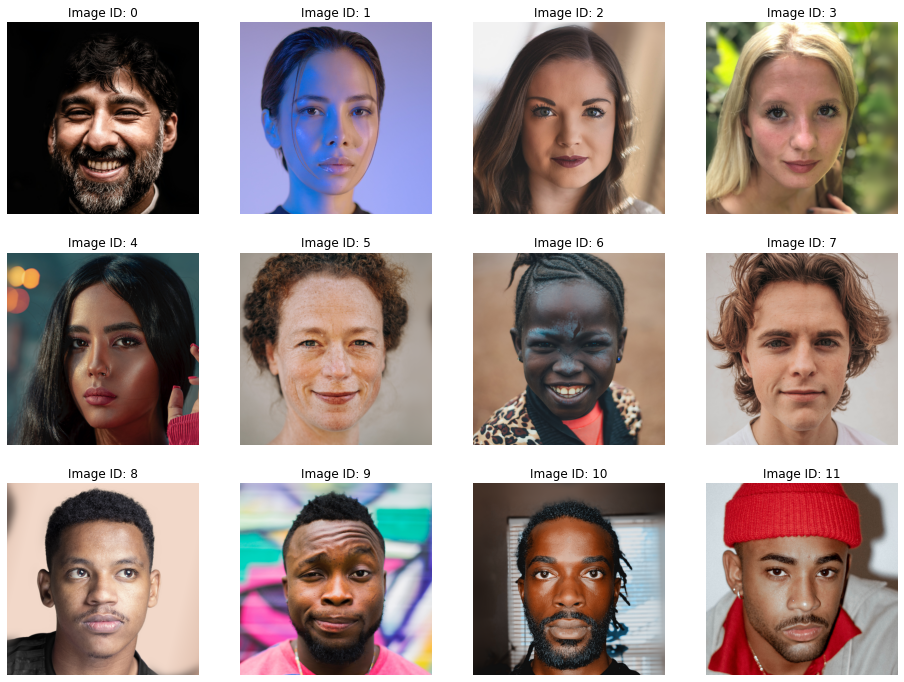

In [ ]:
display_data(data)

## Embedding one image


In this process, we try to adjust the embedding_latent in such a way that the synthetic image is the same as the original image. To do that, we follow the net steps: 

1. Feed the pretrained generator with the embedding latent and get the synthetic image
2. Calculate the loss between the synthetic image and the original image
2. Backward the gradients and apply the optimization

Note: additionally we save the generated image, and the current embedding_latent every 100 steps

In [ ]:
def run_optimization(data, id, init, save_loss = False):

  # get the image sample
  if isinstance(id, int):
    basename = data[id]['name'].split(".")[0]
    img = torch.tensor(data[id]['img'].copy(), device = DEVICE, dtype = torch.float32)
    img = img.permute(2, 0, 1).unsqueeze(0)
  elif isinstance(id, list):
    images = []
    basename = ""
    for idx in id:
      images.append(data[idx]['img'].copy())
      basename += "_" + data[idx]['name'].split(".")[0]
    
    img = torch.tensor(np.array(images), device = DEVICE, dtype = torch.float32)
    img = img.permute(0,3, 1, 2)
  
  # extract the feature of the reference image
  if img.shape[2] > 256:
     tmp_img = F.interpolate(img, size=(256, 256), mode='area')
  target_features = perceptual_vgg16(tmp_img, resize_images=False, return_lpips=True)

  # normalize the image to [0,1] to measure MSE loss
  img = img / 255.0
  
  # define the init latent
  if init == "w_mean":
    w_opt = get_mean_latent()
  elif init == "w_zeros":
    w_opt = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  elif init == "w_random":
    w_opt = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()


  optimizer = optim.Adam({w_opt},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

  print("Starting Embedding: id: {} name: {}".format(id,basename))
  loss_list=[]
  loss_mse=[]
  loss_perceptual=[]
  latent_list = {}
  for i in range(0,ITERATIONS):
      # reset the gradients
      optimizer.zero_grad()

      # get the synthetic image
      synth_img = G.synthesis(w_opt, noise_mode='const')
      
      # get the loss and backpropagate the gradients
      mse_loss, perceptual_loss, regularizer_term = calculate_loss(synth_img,
                                                img,
                                                target_features,
                                                w_opt,
                                                perceptual_vgg16, 
                                                MSE_Loss, 
                                                affine_PN)
      loss = mse_loss + perceptual_loss + regularizer_term
      loss.backward()

      optimizer.step()

      # store the losses metrics
      loss_list.append(loss.item())
      loss_mse.append(mse_loss.item())
      loss_perceptual.append(perceptual_loss.item())

      # every SAVE_STEP, I store the current latent
      if (i +1) % SAVE_STEP == 0:
          print('iter[%d]:\t loss: %.4f\t mse_loss: %.4f\tpercep_loss: %.4f\tregularizer: %.4f' % (i+1,  
                                                                                                   loss.item(), 
                                                                                                   mse_loss.item(), 
                                                                                                   perceptual_loss.item(),
                                                                                                   regularizer_term.item()))
          latent_list[str(i+1)] = w_opt.detach().cpu().numpy()

  # store all the embeddings create during optimization in .npz
  path_embedding_latent = os.path.join(SAVING_DIR, 
                                      "latents/{}_latents_iters_{}_step_{}_{}.npz".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init))
  print("Saving: {}".format(path_embedding_latent))
  np.savez(path_embedding_latent, **latent_list)

  if save_loss:
    loss_file = "loss_plots/{}_loss_iters_{}_step_{}_{}.npy".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init)
    path_loss = os.path.join(SAVING_DIR, loss_file)
    print("Saving Loss: {}".format(path_loss))
    np.save(path_loss, np.array(loss_list))
  return loss_list

## Experiments

In [ ]:
# I fixed the max iteration
ITERATIONS = 1300

In [ ]:
# VGG-16 perceptual lpips loss
loss_alex_w_mean_norm = run_optimization(data, id = 2, init = 'w_mean', save_loss = True)

Starting Embedding: id: 2 name: aleksandr-minakov-xDyqR14KyAs-unsplash
iter[100]:	 loss: 0.2184	 mse_loss: 0.0082	percep_loss: 0.2092	regularizer: 0.0010
iter[200]:	 loss: 0.1802	 mse_loss: 0.0061	percep_loss: 0.1731	regularizer: 0.0011
iter[300]:	 loss: 0.1610	 mse_loss: 0.0050	percep_loss: 0.1548	regularizer: 0.0012
iter[400]:	 loss: 0.1480	 mse_loss: 0.0043	percep_loss: 0.1425	regularizer: 0.0013
iter[500]:	 loss: 0.1382	 mse_loss: 0.0038	percep_loss: 0.1330	regularizer: 0.0014
iter[600]:	 loss: 0.1305	 mse_loss: 0.0034	percep_loss: 0.1257	regularizer: 0.0014
iter[700]:	 loss: 0.1241	 mse_loss: 0.0032	percep_loss: 0.1194	regularizer: 0.0015
iter[800]:	 loss: 0.1200	 mse_loss: 0.0029	percep_loss: 0.1156	regularizer: 0.0015
iter[900]:	 loss: 0.1131	 mse_loss: 0.0026	percep_loss: 0.1089	regularizer: 0.0016
iter[1000]:	 loss: 0.1101	 mse_loss: 0.0025	percep_loss: 0.1059	regularizer: 0.0017
iter[1100]:	 loss: 0.1035	 mse_loss: 0.0023	percep_loss: 0.0995	regularizer: 0.0017
iter[1200]:	 l

In [ ]:
# VGG-16 perceptual lpips loss
for i in range(len(data)):
  loss_alex_w_mean_norm = run_optimization(data, id = i, init = 'w_mean', save_loss = True)

Starting Embedding: id: 0 name: aatik-tasneem-7omHUGhhmZ0-unsplash
iter[100]:	 loss: 0.2081	 mse_loss: 0.0136	percep_loss: 0.1928	regularizer: 0.0017
iter[200]:	 loss: 0.1768	 mse_loss: 0.0125	percep_loss: 0.1628	regularizer: 0.0014
iter[300]:	 loss: 0.1606	 mse_loss: 0.0116	percep_loss: 0.1476	regularizer: 0.0015
iter[400]:	 loss: 0.1521	 mse_loss: 0.0111	percep_loss: 0.1388	regularizer: 0.0022
iter[500]:	 loss: 0.1440	 mse_loss: 0.0105	percep_loss: 0.1318	regularizer: 0.0016
iter[600]:	 loss: 0.1388	 mse_loss: 0.0102	percep_loss: 0.1269	regularizer: 0.0017
iter[700]:	 loss: 0.1352	 mse_loss: 0.0101	percep_loss: 0.1234	regularizer: 0.0017
iter[800]:	 loss: 0.1320	 mse_loss: 0.0098	percep_loss: 0.1206	regularizer: 0.0017
iter[900]:	 loss: 0.1327	 mse_loss: 0.0097	percep_loss: 0.1207	regularizer: 0.0022
iter[1000]:	 loss: 0.1259	 mse_loss: 0.0094	percep_loss: 0.1144	regularizer: 0.0021
iter[1100]:	 loss: 0.1231	 mse_loss: 0.0092	percep_loss: 0.1118	regularizer: 0.0020
iter[1200]:	 loss:

In [ ]:
#@title Function to load latents
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [ ]:
#@title Function to plot loss

# Function to plot the loss per iteration
def plot_loss(losses, basename,  save = False):

  plt.figure()
  scale_factor = 5

  plt.title("Loss During Embedding")
  for label, loss_file in losses.items():
    loss = np.load(os.path.join(SAVING_DIR, "loss_plots/" + loss_file))
    plt.plot(loss,label=label)
  plt.xlabel("Optimization Steps")
  plt.ylabel("Loss")
  plt.legend()
  

  if save:
    file_dir = os.path.join(SAVING_DIR, "loss_plots/{}_losses_iters_{}.svg".format(basename, str(ITERATIONS).zfill(6)))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)
    
  plt.show()

In [ ]:
#@title Function to plot the synthetic image per iterations

def show_images_results(data, id, latents_file, iterations_to_show, subfix = "", expected_result = False, save = False, save_last = False):

    latent_codes = load_latents(latents_file)
    base_name = latents_file.split(".")[0]

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    if expected_result: n_images += 1
    fig, axs = plt.subplots(1,n_images ,figsize=(inches * n_images , inches))

    # original image
    axs[0].imshow(data[id]['img'])
    axs[0].set_title('Original')
    axs[0].axis('off')

    # embeddings per iterations
    idx = 1
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = G.synthesis(tensor_latent, noise_mode='const')
        synth_img = (synth_img + 1.0) / 2.0
        
        if save_last and iter == iterations_to_show[-1]:
          print("Saving last image...")
          save_image(synth_img.clamp(0,1), os.path.join(SAVING_DIR,"images/last_generated/{}.png".format(base_name)))

        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')



        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    # expected result
    if expected_result:
      with open(EXPECTED_RESULTS + data[id]['name'],"rb") as f:
          image=Image.open(f)
          axs[idx].imshow(image)
          axs[idx].set_title('Expected Result')
          axs[idx].axis('off')

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}{}.svg".format(
          base_name,
          subfix))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)

            

In [ ]:
!ls $SAVING_DIR/loss_plots

aatik-tasneem-7omHUGhhmZ0-unsplash_loss_iters_001300_step_0100_w_mean.npy
aiony-haust-3TLl_97HNJo-unsplash_loss_iters_001300_step_0100_w_mean.npy
aleksandr-minakov-xDyqR14KyAs-unsplash_loss_iters_001300_step_0100_w_mean.npy
alex-lee-l7oI8wCfQ8Y-unsplash_loss_iters_001300_step_0100_w_mean.npy
amin-rk-QKxRH1sAfYY-unsplash_loss_iters_001300_step_0100_w_mean.npy
andrew-heald-z2wyh1Maq8E-unsplash_loss_iters_001300_step_0100_w_mean.npy
annie-spratt-ZyWN6N41JUc-unsplash_loss_iters_001300_step_0100_w_mean.npy
austin-wade-X6Uj51n5CE8-unsplash_loss_iters_001300_step_0100_w_mean.npy
awab-husameldin-678MnkzVdRU-unsplash_loss_iters_001300_step_0100_w_mean.npy
ayo-ogunseinde-sibVwORYqs0-unsplash_loss_iters_001300_step_0100_w_mean.npy
dorrell-tibbs-gisFZKWpKQ4-unsplash_loss_iters_001300_step_0100_w_mean.npy
no_square_regularizer
pexels-wallace-chuck-4580470_loss_iters_001300_step_0100_w_mean.npy


In [ ]:
losses_files = sorted(os.listdir(os.path.join(SAVING_DIR,"loss_plots")))
losses_files = [loss_name for loss_name in losses_files if ".npy" in loss_name ]

In [ ]:
losses = {"losst_image_{}".format(idx) : loss_file for idx, loss_file in enumerate(losses_files) }

Saving: stuff/results/synthetic_images_regulizer_v2/loss_plots/losses_per_image_losses_iters_001300.svg


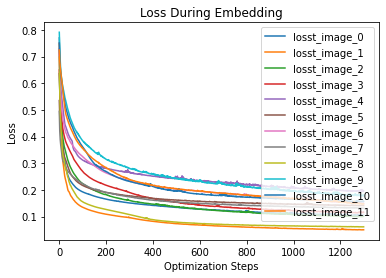

In [ ]:
# plot losses
plot_loss(losses, basename = "losses_per_image",save = True)

In [ ]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = [f for f in latents_files if ".npz" in f]
latents_files

['aatik-tasneem-7omHUGhhmZ0-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'aiony-haust-3TLl_97HNJo-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'aleksandr-minakov-xDyqR14KyAs-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'alex-lee-l7oI8wCfQ8Y-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'amin-rk-QKxRH1sAfYY-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'andrew-heald-z2wyh1Maq8E-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'annie-spratt-ZyWN6N41JUc-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'austin-wade-X6Uj51n5CE8-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'awab-husameldin-678MnkzVdRU-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'ayo-ogunseinde-sibVwORYqs0-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'dorrell-tibbs-gisFZKWpKQ4-unsplash_latents_iters_001300_step_0100_w_mean.npz',
 'pexels-wallace-chuck-4580470_latents_iters_001300_step_0100_w_mean.npz']

Saving: stuff/results/synthetic_images_regulizer_v2/images/ayo-ogunseinde-sibVwORYqs0-unsplash_latents_iters_001300_step_0100_w_mean.svg


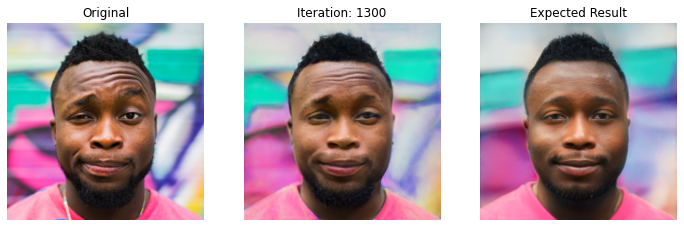

In [ ]:
show_images_results(data, 9, latents_files[9], [1300],expected_result=True, save=True, save_last=False)

RuntimeError: ignored

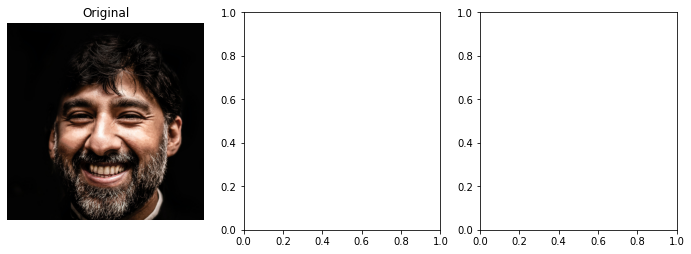

In [ ]:
for i in range(12):
  show_images_results(data, i, latents_files[i], [1300],expected_result=True, save=True, save_last=True)

# Checking Quantitative Metrics


In [ ]:
!ls $SAVING_DIR/images/no_square_regularizer_lambda_0-001/last_generated

aatik-tasneem-7omHUGhhmZ0-unsplash_latents_iters_001300_step_0100_w_mean.png
aiony-haust-3TLl_97HNJo-unsplash_latents_iters_001300_step_0100_w_mean.png
aleksandr-minakov-xDyqR14KyAs-unsplash_latents_iters_001300_step_0100_w_mean.png
alex-lee-l7oI8wCfQ8Y-unsplash_latents_iters_001300_step_0100_w_mean.png
amin-rk-QKxRH1sAfYY-unsplash_latents_iters_001300_step_0100_w_mean.png
andrew-heald-z2wyh1Maq8E-unsplash_latents_iters_001300_step_0100_w_mean.png
annie-spratt-ZyWN6N41JUc-unsplash_latents_iters_001300_step_0100_w_mean.png
austin-wade-X6Uj51n5CE8-unsplash_latents_iters_001300_step_0100_w_mean.png
awab-husameldin-678MnkzVdRU-unsplash_latents_iters_001300_step_0100_w_mean.png
ayo-ogunseinde-sibVwORYqs0-unsplash_latents_iters_001300_step_0100_w_mean.png
dorrell-tibbs-gisFZKWpKQ4-unsplash_latents_iters_001300_step_0100_w_mean.png
pexels-wallace-chuck-4580470_latents_iters_001300_step_0100_w_mean.png


## Reconstruction Metrics

### Peak signal-to-noise ratio (PSNR)

PSNR is most easily defined via the mean squared error (MSE). Given a noise-free $m\times n$ monochrome image $I$ and its noisy approximation $K$, MSE is defined as:

$$M S E=\frac{1}{m n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1}[I(i, j)-K(i, j)]^{2} $$


The PSNR is defined as:

$$
\begin{aligned}
P S N R &=10 \cdot \log _{10}\left(\frac{M A X_{I}^{2}}{M S E}\right) \\
&=20 \cdot \log _{10}\left(\frac{M A X_{I}}{\sqrt{M S E}}\right) \\
&=20 \cdot \log _{10}\left(M A X_{I}\right)-10 \cdot \log _{10}(M S E)
\end{aligned}
$$

Here, $MAX_I$ is the maximum possible pixel value of the image.


In [ ]:
#@title build_tensor_results 
#@markdown Load the generated imgs with its respective reference img
def build_tensor_results(path_generated_imgs):
  input_data = load_data(PATH_DIR)

  path_generated_imgs = os.path.join(SAVING_DIR,path_generated_imgs)
  generated_imgs = load_data(path_generated_imgs)

  full_batches = []

  for i in range(12):
    references = input_data[i]['img']
    synthetics = generated_imgs[i]['img']

    batch_data = np.stack([synthetics, references], axis = 0)

    full_batches.append(batch_data)

  full_batches = np.array(full_batches)
  print("full_batches numpy: ", full_batches.shape)

  # convert to pytorch tensor
  full_batches = torch.tensor(full_batches, device = DEVICE, dtype = torch.float32)
  full_batches = full_batches.permute(0, 1, 4, 2, 3)
  print("full_batches tensor: ", full_batches.size())

  return full_batches

In [ ]:
full_batches = build_tensor_results("images/no_square_regularizer_lambda_0-001/last_generated/")
full_batches.size()

full_batches numpy:  (12, 2, 1024, 1024, 3)
full_batches tensor:  torch.Size([12, 2, 3, 1024, 1024])


torch.Size([12, 2, 3, 1024, 1024])

In [ ]:
def get_PSNR(full_batches):
  def process_function(engine, batch):
      y_pred = batch[0]
      y = batch[1]
      return y_pred, y

  engine = Engine(process_function)
  psnr = PSNR(data_range=255.0)
  psnr.attach(engine, "psnr")

  state = engine.run(full_batches)
  print(f"n_imgs: {full_batches.size(0)} PSNR: {state.metrics['psnr']}")

  return state.metrics['psnr']

In [ ]:
psnr_metric = get_PSNR(full_batches)

n_imgs: 12 PSNR: 23.279572988230957


## Root Mean Square Deviation (RMSD)

Given two $m\times n$ images $I_1$ and $I_2$

$$M S E=\frac{1}{m n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1}[I_1(i, j)-I_2(i, j)]^{2} $$

Then, RMSD is

$$
\mathrm{RMSD}=\sqrt{MSE}
$$

In [ ]:
def get_RMSD(full_batches):
  generates = full_batches[:,0,:,:,:] / 255.0
  references = full_batches[:,1,:,:,:] / 255.0

  criterion = nn.MSELoss()
  rmsd = torch.sqrt(criterion(generates, references))

  print(f"n_imgs: {full_batches.size(0)} RMSD: {rmsd}")
  return rmsd

In [ ]:
get_RMSD(full_batches)

n_imgs: 12 RMSD: 0.07621462643146515


tensor(0.0762, device='cuda:0')

## VGG perceptual similarity

In [ ]:
#@title the VGG16 Perceptual Network

class PerceptualVGG16(torch.nn.Module):
    def __init__(self, requires_grad=False, n_layers=[2, 4, 14, 21]):
        super(PerceptualVGG16, self).__init__()
        
        # Dowsampling according to input of ImageNet 256x256
        self.upsample2d = torch.nn.Upsample(scale_factor=256/RESOLUTION, mode='bicubic')

        # Get the pretrained vgg16 model
        vgg_pretrained_features = models.vgg16(pretrained=True).features

        self.slice0 = torch.nn.Sequential()
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        
        # [0,1] layers indexes
        for x in range(n_layers[0]):  
            self.slice0.add_module(str(x), vgg_pretrained_features[x])\
            
        # [2, 3] layers indexes
        for x in range(n_layers[0], n_layers[1]):  # relu1_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        
        # [4, 13] layers indexes
        for x in range(n_layers[1], n_layers[2]): # relu3_2
            self.slice2.add_module(str(x), vgg_pretrained_features[x])

        # [14, 20] layers indexes
        for x in range(n_layers[2], n_layers[3]):# relu4_2
            self.slice3.add_module(str(x), vgg_pretrained_features[x])

        # Setting the gradients to false
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False
                
    def forward(self, x):
        upsample = self.upsample2d(x)
        
        h0 = self.slice0(upsample)
        h1 = self.slice1(h0)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)

        return h0, h1, h2, h3

In [ ]:
def get_vgg_perceptual(full_batches, separate = True):
  url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
  with dnnlib.util.open_url(url) as f:
      perceptual_vgg16 = torch.jit.load(f).eval().to(DEVICE)

  generates = full_batches[:,0,:,:,:].clone() / 255.0
  references = full_batches[:,1,:,:,:].clone() / 255.0

  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  generates = normalize(generates)
  references = normalize(references)

  perceptual_net = PerceptualVGG16(n_layers=[2,4,14,21]).to(DEVICE)

  def get_loss(synth_img, original_img):
    real_0,real_1,real_2,real_3 = perceptual_net(original_img)
    synth_0,synth_1,synth_2,synth_3 = perceptual_net(synth_img)

    perceptual_loss=0
    perceptual_loss+=MSE_Loss(synth_0,real_0)
    perceptual_loss+=MSE_Loss(synth_1,real_1)
    perceptual_loss+=MSE_Loss(synth_2,real_2)
    perceptual_loss+=MSE_Loss(synth_3,real_3)

    return perceptual_loss

  if separate:
    perceptual_per_img = []

    for i in range(full_batches.size(0)):
      
      perceptual_loss = get_loss(generates[i].unsqueeze(0), references[i].unsqueeze(0))

      perceptual_per_img.append(perceptual_loss.item())

    metric = np.mean(perceptual_per_img)
  else:

    metric = get_loss(generates, references)

  print(f"n_imgs: {full_batches.size(0)} VGG: {metric}")

  return metric

In [ ]:
get_vgg_perceptual(full_batches, separate=False)

n_imgs: 12 VGG: 0.46020573377609253


tensor(0.4602, device='cuda:0')

## LPIPS Perceptual Metric

In [ ]:
def get_lpips(full_batches, separate = True):
  url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
  with dnnlib.util.open_url(url) as f:
      perceptual_vgg16 = torch.jit.load(f).eval().to(DEVICE)

  generates = full_batches[:,0,:,:,:].clone()
  references = full_batches[:,1,:,:,:].clone()

  generates = F.interpolate(generates, size=(256, 256), mode='area')
  references = F.interpolate(references, size=(256, 256), mode='area')
  
  perceptual_per_img = []

  
  if separate:
    for i in range(full_batches.size(0)):

      synth_features = perceptual_vgg16(generates[i].unsqueeze(0), resize_images=False, return_lpips=True)
      reference_features = perceptual_vgg16(references[i].unsqueeze(0), resize_images=False, return_lpips=True)

      perceptual_loss = (reference_features - synth_features).square().sum()

      perceptual_per_img.append(perceptual_loss.item())

    metric = np.mean(perceptual_per_img)
  else:
    synth_features = perceptual_vgg16(generates, resize_images=False, return_lpips=True)
    reference_features = perceptual_vgg16(references, resize_images=False, return_lpips=True)

    metric = (reference_features - synth_features).square().sum()

  print(f"n_imgs: {full_batches.size(0)} LPIPS: {metric}")

  return metric

In [ ]:
get_lpips(full_batches)

n_imgs: 12 LPIPS: 0.1154733073587219


0.1154733073587219

## Differentiable structural similarity (SSIM) index.

In [ ]:
def get_SSIM(full_batches):
  generates = full_batches[:,0,:,:,:]
  references = full_batches[:,1,:,:,:]

  metric = ssim(generates, references,data_range=255.0)

  print(f"n_imgs: {full_batches.size(0)} LPIPS: {metric}")

  return metric

In [ ]:
get_SSIM(full_batches)

n_imgs: 12 LPIPS: 0.705211877822876


tensor(0.7052, device='cuda:0')